# Understanding the Impact of Image Quality and Distance of Objects to Object Detection Performance

***A reproduction*** 

## Load Data

## Train/Load Model

## Visualizing Results

#### Reproducing figures from the paper

#### Figure 5

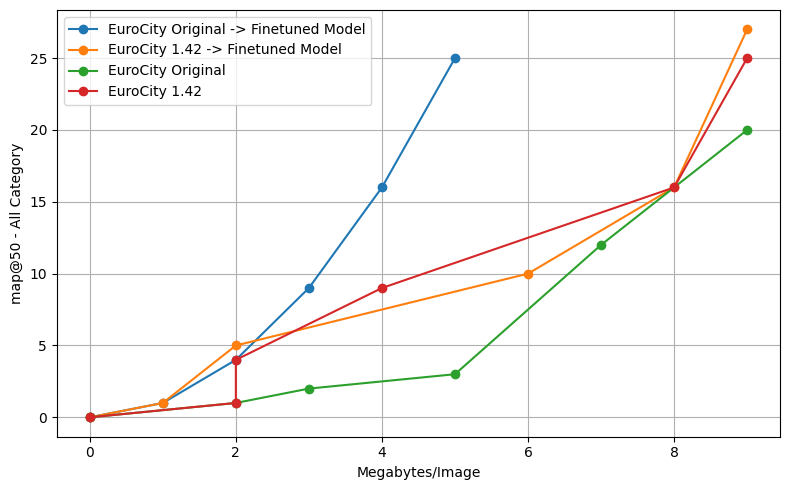

In [ ]:
from visualization.xy_lineplot import basic_lineplot, multi_lineplot


data_dict = {
    "EuroCity Original -> Finetuned Model": ([0, 1, 2, 3, 4, 5], [0, 1, 4, 9, 16, 25]),
    "EuroCity 1.42 -> Finetuned Model": ([0, 1, 2, 6, 8, 9], [0, 1, 5, 10, 16, 27]),
    "EuroCity Original": ([0, 2, 3, 5, 7, 9], [0, 1, 2, 3, 12, 20]), 
    "EuroCity 1.42": ([0, 2, 2, 4, 8, 9], [0, 1, 4, 9, 16, 25])
}
## Figure 5 in the paper 
multi_lineplot(data_dict, xlabel="Megabytes/Image", ylabel="map@50 - All Category")

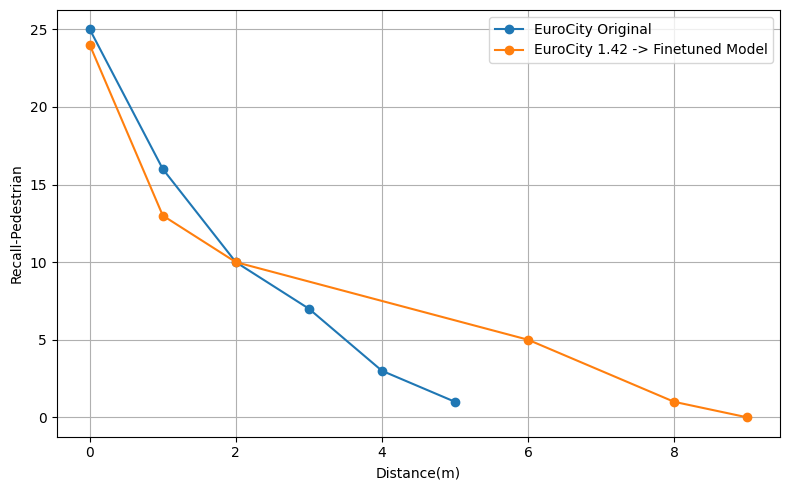

In [5]:
from visualization.xy_lineplot import basic_lineplot, multi_lineplot


data_dict = {
    "EuroCity Original": ([0, 1, 2, 3, 4, 5], [25, 16, 10, 7, 3, 1]),
    "EuroCity 1.42 -> Finetuned Model": ([0, 1, 2, 6, 8, 9], [24, 13, 10, 5, 1, 0]),
}
## Figure 5 in the paper 
multi_lineplot(data_dict, xlabel="Distance(m)", ylabel="Recall-Pedestrian")